# Сафарян Анна, Егорова Алина
## Финский

* [**Типология языков**](#typology)
* [**Чтение данных**](#data)
* [**Дескриптивная статистика и задание параметров корпуса**](#ststs)
* [**Кодирование последовательностей и создание генератора**](#encode)
* [**Создание и обучение упрощённых моделей**](#easy-train)
    * [SimpleRNN](#easy-simple)
    * [LSTM](#easy-lstm)
    * [BiLSTM](#easi-bilstm)
    * [GRU](#easy-gru)
* [Построение графиков и определение переобучения для упрощённых моделей](#easy-graphs)
* [Оценка и сравнение упрощённых моделей](#easy-choose)
* [**Эксперименты с эмбеддингами**](#embed)

In [1]:
import conllu
import numpy as np
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from os import makedirs
import matplotlib.pyplot as plt
from json import dump, load
from collections import defaultdict
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

Using TensorFlow backend.


## Типология языков <a id="typology"></a>

| Типология | Старославянский | Финский |
|------------- |---------------|-------------|
| **Генеалогическая: семья**  | Индоевропейская | Уральская | 
| **Генеалогическая: ветвь** | Славянские | Финно-угорские |
| **Морфологическая** | Синтетический (флективный) | Синтетический (агглютинативный) |
| **Морфосинтаксическая** | Номинативный | Номинативный |
| **Порядок слов: ветвление** | SVO, левое | SVO, левое |
| **Порядок слов: свобода** | свободный | относительно свободный |


Код в точности повторяет аналогичный для старославянского, так что его, наверное, особо комментировать смысла нет

## Чтение данных <a id="вфеф"></a>

In [2]:
train_raw = open('fi\\fi-train.conllu', 'r', encoding='utf-8').read().lower()
train_data = conllu.parse(train_raw)
print(len(train_data))
test_raw = open('fi\\fi-test.conllu', 'r', encoding='utf-8').read().lower()
test_data = conllu.parse(test_raw)
print(len(test_data))

14981
1867


Пусть текстов будет примерно столько же, сколько и для старославянского. Перемешаем корпуса (позже я подмала, что неплохо бы использовать тут StratifiedShuffleSplit, но уже слишком поздно)

In [3]:
train_data = shuffle(train_data)[:4000]
test_data = shuffle(test_data)[:1000]

Для старославянскго тексты не лемматизировали, так что и для финского не будем

In [4]:
def get_data(data):
    sents = [] # список списков токенов
    tags = [] # список списков тегов
    word_vocab = set() # множество уникальных токенов
    pos_vocab = set() # множество уникальных 
    pos_freq = defaultdict(int) # частота встречаемостиpos-тегов
    for l in data:
        sent = []
        tag = []
        for tok in l:
            #print(tok)
            sent.append(tok['form'])
            tag.append(tok['upostag'])
            word_vocab.add(tok['form'])
            pos_vocab.add(tok['upostag'])
            pos_freq[tok['upostag']] += 1
        sents.append(sent)
        tags.append(tag)
    return sents, tags, word_vocab, pos_vocab, dict(pos_freq)

In [5]:
train_sents, train_tags, train_word_vocab, train_pos_vocab, train_pos_freq = get_data(train_data)
test_sents, test_tags, test_word_vocab, test_pos_vocab, test_pos_freq = get_data(test_data)

In [6]:
for s, t in zip(train_sents[:3], train_tags[:3]):
    print(s)
    print(t)
    print()
print(train_pos_vocab)
#print(train_word_vocab)

['pankit', 'ovat', 'pitäneet', 'tiedotustilaisuutensa', 'ja', 'kertoneet', 'uusista', 'sijoitus-', ',', 'määräaikais-', ',', 'tuotto-', 'ja', 'voittotileistään', '.']
['noun', 'verb', 'verb', 'noun', 'cconj', 'verb', 'adj', 'x', 'punct', 'x', 'punct', 'x', 'cconj', 'noun', 'punct']

['ootte', 'te', 'mahtavia', 'jätkiä', '.']
['aux', 'pron', 'adj', 'noun', 'punct']

['sipuli', 'kypsyy', 'pannulla']
['noun', 'verb', 'noun']

{'verb', 'pron', 'noun', 'adv', 'intj', 'det', 'propn', 'cconj', 'sym', '_', 'aux', 'sconj', 'num', 'adp', 'punct', 'adj', 'part', 'x'}


In [7]:
# словари соответствий строим по тренировочной выборке
w2i = {'pad':0, 'unk':1} # за 0 закреплены слова pad, за 1 -- unk, т.е. слова тестовой, которых нет в тренировочной
i2w = {0:'pad', 1:'unk'}

for i, w in enumerate(train_word_vocab):
   w2i[w] = i+2 # прибавляем 2, т.к. добавили 2 своих слова
   i2w[i+2] = w
    
t2i = {'pad':0} # теги для незнакомых слов попробуем предсказывать тоже
i2t = {0:'pad'}
for i, t in enumerate(train_pos_vocab):
   t2i[t] = i+1
   i2t[i+1] = t

print(t2i)

{'pad': 0, 'verb': 1, 'pron': 2, 'noun': 3, 'adv': 4, 'intj': 5, 'det': 6, 'propn': 7, 'cconj': 8, 'sym': 9, '_': 10, 'aux': 11, 'sconj': 12, 'num': 13, 'adp': 14, 'punct': 15, 'adj': 16, 'part': 17, 'x': 18}


In [8]:
# заменяем все незнакомые слова в тестовой выборке на unk
test_sents_clean = test_sents[:]
count_test_words = 0
count_unk = 0
for s, sent in enumerate(test_sents):
    for w, word in enumerate(sent):
        count_test_words+=1
        if word not in train_word_vocab: # если слова нет в словаре тренировочной выборки
            test_sents_clean[s][w] = 'unk' # заменяем слово в "чистой" тестовой выборке
            count_unk+=1
print(count_test_words)
print(count_unk)
print(test_sents_clean[:10])

8822
2894
[['vasta', 'syksyllä', 'kun', 'unk', 'unk', 'unk', ',', 'meidän', 'on', 'unk', 'töihin', 'unk'], ['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', '.'], ['voi', 'kun', 'olisi', 'edes', '100', 'unk', 'enemmän', 'ari', 'unk', 'unk', '.'], ['ja', 'kuitenkin', 'tiesin', ',', 'että', 'unk', 'ei', 'voinut', ',', 'ei', 'tästä', 'unk', ',', 'ei', 'enää', '.'], ['abdi', 'sanoi', 'että', 'hän', 'voi', 'kantaa', 'unk', 'pöydän', 'ja', 'pari', 'unk', 'unk', 'jos', 'olut', 'viedään', 'itse', '.'], ['unk', 'on', 'vanha', 'unk', ',', 'joka', 'unk', 'tulla', 'unk', 'unk', 'unk', '.'], ['tiesin', ',', 'milloin', 'unk', 'unk', 'unk', 'unk', '.'], ['unk', 'näytti', 'siltä', 'kuin', 'ei', 'olisi', 'ikinä', 'kuullut', 'koko', 'sanaa', '.'], ['unk', 'on', 'paikka', ',', 'missä', 'unk', 'unk', 'miehet', 'tai', 'naiset', 'unk', 'unk', '.'], ['runsas', 'viikko', 'unk', 'unk', 'unk', 'hengiltä', 'unk', 'unk']]


## Дескриптивная статистика <a id="stats"></a>
* Число предложений / уникальных словоформ;
* Число уникальных PoS-тегов;
* Максимальное и минимальное число слов в предложении;
* Математическое ожидание и медиана числа слов в предложении;
* Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке

In [9]:
train_lens = [len(i) for i in train_sents]
print(train_lens[:20])
test_lens = [len(i) for i in test_sents_clean]
print(test_lens[:20])
dif = len(test_word_vocab-train_word_vocab)*100/(len(test_word_vocab)+2) # сколько есть "незнакомых" слов в словаре тестовой выборки
pr = count_unk*100/count_test_words # сколько процентов такие слова составляют от тестового корпуса 

print('''
\t\tTrain\tTest
n_sents:\t{}\t{}
n_words:\t{}\t{}
n_tags: \t{}\t{}
max_len:\t{}\t{}
min_len:\t{}\t{}
mean_len:\t{}\t{}
med_len:\t{}\t{}
{}% тестового словаря нет в тренировочном. Это {}% тестового корпуса.
'''.format(
    len(train_lens), len(test_lens),
    len(train_word_vocab)+2, len(test_word_vocab)+2, # нормальные слова + pad, unk 
    len(train_pos_vocab)+1, len(test_pos_vocab)+1, # нормальные теги + pad
    np.max(train_lens), np.max(test_lens), 
    np.min(train_lens), np.min(test_lens), 
    round(np.mean(train_lens), 1), round(np.mean(test_lens), 1), 
    round(np.median(train_lens), 1), round(np.median(test_lens), 1),
    round(dif,2), round(pr,2)))

[15, 5, 3, 3, 15, 4, 8, 8, 6, 9, 3, 16, 5, 20, 5, 7, 8, 5, 4, 12]
[12, 9, 11, 16, 17, 12, 8, 11, 13, 8, 15, 4, 4, 18, 16, 11, 9, 6, 7, 13]

		Train	Test
n_sents:	4000	1000
n_words:	13809	4630
n_tags: 	19	18
max_len:	68	33
min_len:	1	1
mean_len:	8.5	8.8
med_len:	7.0	8.0
60.35% тестового словаря нет в тренировочном. Это 32.8% тестового корпуса.



In [10]:
# какой-то из редких тегов не попался в тестовой выборке, добавим его в словарь частот вручную, чтобы не было проблем с гистограммой
rare = list(train_pos_vocab-test_pos_vocab)[0]
print(rare)
test_pos_freq[rare] = 0

sym


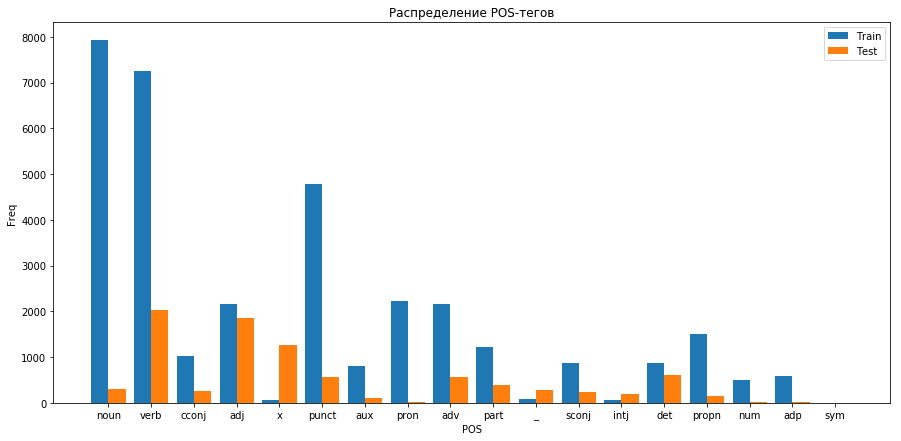

In [14]:
plt.subplots(figsize=(15, 7))

plt.bar(np.arange(18)-0.2, list(train_pos_freq.values()), 0.4, label = 'Train')
plt.bar(np.arange(18)+0.2, list(test_pos_freq.values()), 0.4, label = 'Test')
plt.xlabel('POS')
plt.ylabel('Freq')
plt.title('Распределение POS-тегов')
plt.xticks(np.arange(18), list(train_pos_freq.keys()))
plt.legend()
plt.show()

In [15]:
max_len = np.max(train_lens) 
n_words = len(train_word_vocab)+2
n_tags = len(train_pos_vocab)+1
batch_size = 64

## Кодирование последовательностей и создание генератора <a id="encode"></a>

In [16]:
# кодируем последовательности и дополняем их нулями до максимальной длины
def encode_sequences(sequences, dict2index, maxlen=max_len):
    enc_seqs = [[dict2index[word] for word in seq[:maxlen]] for seq in sequences] # предложение урезаем до максимальной длины в тренировочной выборке
    enc_seqs = pad_sequences(enc_seqs, maxlen, padding='post')
    return enc_seqs

In [17]:
# унитарно кодируем метки (принимаем уже закодированные на предыдущем шаге последователности)
def onehot_sequences(sequences):
    enc_seqs = []
    for sequence in sequences: 
        encoded = to_categorical(sequence, num_classes=n_tags) 
        enc_seqs.append(encoded)
    enc_seqs = np.array(enc_seqs)
    return enc_seqs

In [18]:
# проверим, как работает
es = encode_sequences(test_sents_clean[:2], dict2index=w2i, maxlen=10) # возьмём не 92, а 10, чтобы нормально отобразились матрицы, а то они иначе сжимаются посередине
et = encode_sequences(test_tags[:2], dict2index=t2i, maxlen=10)
print(es.shape)
et = onehot_sequences(et) 
print(et.shape)
for i in range(2):
    print(test_sents[i]),
    print(es[i], len(es[i])),
    print(test_tags[i]),
    print(et[i], len(et[i])),
    print()
# видно, что короткие дополняются, длинные обрезаются

(2, 10)
(2, 10, 19)
['vasta', 'syksyllä', 'kun', 'unk', 'unk', 'unk', ',', 'meidän', 'on', 'unk', 'töihin', 'unk']
[   46  8365  4152     1     1     1  6951  8992 10779     1] 10
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 10

['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', '.']
[    1     1     1     1     1     1     1     1 13627 

In [19]:
# генератор батчей
def gen_batch(sents, tags, batch_size):
    i = 0
    all_sents  = len(sents) # всего последовательностей
    n_sents = batch_size * int(all_sents / batch_size)  #сколько у нас влезет (батч * кол-во батчей)
    #print(n_sents)
    while True:
        #print(i)
        i = i % n_sents # считаем текущий индекс (где новое) \\ПОЧЕМУ ЮЕЗ ЭТОЙ СТРОЧКИ КОНЧАЮТСЯ ДАННЫЕ?
        # берём кусочки
        sub_sents = sents[i: i+batch_size]
        sub_tags = tags[i: i+batch_size]

        # кодируем кусочки
        sub_sents = encode_sequences(sub_sents, dict2index=w2i, maxlen=max_len)
        sub_tags = encode_sequences(sub_tags, dict2index=t2i, maxlen=max_len)
        sub_tags = onehot_sequences(sub_tags)
        
        # обновляем текущий индекс
        i += batch_size
        #print(i)
        
        yield sub_sents, sub_tags # возвращаем наши кусочки

In [20]:
# тренировочную выборку поделим на собственно тренировочную и валидационную. Проводить валидацию на тестовой выборке всё-таки не очень хорошо
train_sents, val_sents, train_tags, val_tags = train_test_split(train_sents, train_tags, test_size=0.2, shuffle=True)
print(len(train_sents))
print(len(val_sents))

3200
800


In [21]:
epochs = 10
steps = int(len(train_sents)/batch_size) # считаем шаги для генератора
print(steps)
val_steps = int(len(val_sents)/batch_size)
print(val_steps)
test_steps = int(len(test_sents)/batch_size)
print(test_steps)
n_hidden = 128 # возьмём средненькое, чтобы можно было вверх и вниз менять
embed_size = 100

50
12
15


## Создание и обучение моделей <a id="train"></a>

Раз более сложные архитектуры работают плохо, то сразу перейдём к упрощённым моделям

In [23]:
for model_type in ['simple', 'lstm', 'bilstm', 'gru']:
    try:
        makedirs('fi\\easy-{}'.format(model_type))
    except OSError:
        pass

### SimpleRNN

In [24]:
easy_simple = Sequential()
easy_simple.add(Embedding(n_words, embed_size, input_length=max_len))
easy_simple.add(SimpleRNN(n_hidden, return_sequences=True, unroll=True))
easy_simple.add(Dense(n_tags, activation="softmax"))

easy_simple.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 68, 128)           29312     
_________________________________________________________________
dense_1 (Dense)              (None, 68, 19)            2451      
Total params: 1,412,663
Trainable params: 1,412,663
Non-trainable params: 0
_________________________________________________________________


In [25]:
checkpoint = ModelCheckpoint('fi\\easy-simple\\fi-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_simple_history = easy_simple.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_simple_history.history, open('fi\\easy-simple\\fi-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 14s 275ms/step - loss: 0.6576 - acc: 0.8562 - val_loss: 0.4389 - val_acc: 0.8825

Epoch 00001: saving model to fi\easy-simple\fi-easy_model-1.h5
Epoch 2/10
50/50 [==============================] - 8s 155ms/step - loss: 0.3757 - acc: 0.8960 - val_loss: 0.3483 - val_acc: 0.8965

Epoch 00002: saving model to fi\easy-simple\fi-easy_model-2.h5
Epoch 3/10
50/50 [==============================] - 8s 158ms/step - loss: 0.3081 - acc: 0.9202 - val_loss: 0.3008 - val_acc: 0.9223

Epoch 00003: saving model to fi\easy-simple\fi-easy_model-3.h5
Epoch 4/10
50/50 [==============================] - 8s 154ms/step - loss: 0.2647 - acc: 0.9354 - val_loss: 0.2700 - val_acc: 0.9303

Epoch 00004: saving model to fi\easy-simple\fi-easy_model-4.h5
Epoch 5/10
50/50 [==============================] - 8s 164ms/step - loss: 0.2323 - acc: 0.9427 - val_loss: 0.2454 - val_acc: 0.9342

Epoch 00005: saving model to fi\easy-simple\fi-easy_model-5.h5
Epoch 6/10
50/50 [=

### LSTM

In [26]:
easy_lstm = Sequential()
easy_lstm.add(Embedding(n_words, embed_size, input_length=max_len))
easy_lstm.add(LSTM(n_hidden, return_sequences=True, unroll=True))
easy_lstm.add(Dense(n_tags, activation="softmax"))

easy_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 68, 128)           117248    
_________________________________________________________________
dense_2 (Dense)              (None, 68, 19)            2451      
Total params: 1,500,599
Trainable params: 1,500,599
Non-trainable params: 0
_________________________________________________________________


In [27]:
checkpoint = ModelCheckpoint('fi\\easy-lstm\\fi-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_lstm_history = easy_lstm.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_lstm_history.history, open('fi\\easy-lstm\\fi-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 51s 1s/step - loss: 0.8805 - acc: 0.8579 - val_loss: 0.4370 - val_acc: 0.8751

Epoch 00001: saving model to fi\easy-lstm\fi-easy_model-1.h5
Epoch 2/10
50/50 [==============================] - 14s 281ms/step - loss: 0.4044 - acc: 0.8776 - val_loss: 0.3997 - val_acc: 0.8761

Epoch 00002: saving model to fi\easy-lstm\fi-easy_model-2.h5
Epoch 3/10
50/50 [==============================] - 17s 335ms/step - loss: 0.3660 - acc: 0.8793 - val_loss: 0.3783 - val_acc: 0.8789

Epoch 00003: saving model to fi\easy-lstm\fi-easy_model-3.h5
Epoch 4/10
50/50 [==============================] - 16s 315ms/step - loss: 0.3380 - acc: 0.8865 - val_loss: 0.3487 - val_acc: 0.8950

Epoch 00004: saving model to fi\easy-lstm\fi-easy_model-4.h5
Epoch 5/10
50/50 [==============================] - 15s 301ms/step - loss: 0.3134 - acc: 0.9011 - val_loss: 0.3178 - val_acc: 0.9115

Epoch 00005: saving model to fi\easy-lstm\fi-easy_model-5.h5
Epoch 6/10
50/50 [==========

### BiLSTM

In [28]:
easy_bilstm = Sequential()
easy_bilstm.add(Embedding(n_words, embed_size, input_length=max_len))
easy_bilstm.add(Bidirectional(LSTM(n_hidden, return_sequences=True, unroll=True)))
easy_bilstm.add(Dense(n_tags, activation="softmax"))

easy_bilstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_bilstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 68, 256)           234496    
_________________________________________________________________
dense_3 (Dense)              (None, 68, 19)            4883      
Total params: 1,620,279
Trainable params: 1,620,279
Non-trainable params: 0
_________________________________________________________________


In [29]:
checkpoint = ModelCheckpoint('fi\\easy-bilstm\\fi-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_bilstm_history = easy_bilstm.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_bilstm_history.history, open('fi\\easy-bilstm\\fi-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 143s 3s/step - loss: 0.8106 - acc: 0.8667 - val_loss: 0.3602 - val_acc: 0.8955

Epoch 00001: saving model to fi\easy-bilstm\fi-easy_model-1.h5
Epoch 2/10
50/50 [==============================] - 44s 883ms/step - loss: 0.3328 - acc: 0.8985 - val_loss: 0.3167 - val_acc: 0.9030

Epoch 00002: saving model to fi\easy-bilstm\fi-easy_model-2.h5
Epoch 3/10
50/50 [==============================] - 43s 855ms/step - loss: 0.2990 - acc: 0.9051 - val_loss: 0.2942 - val_acc: 0.9113

Epoch 00003: saving model to fi\easy-bilstm\fi-easy_model-3.h5
Epoch 4/10
50/50 [==============================] - 47s 932ms/step - loss: 0.2755 - acc: 0.9163 - val_loss: 0.2779 - val_acc: 0.9137

Epoch 00004: saving model to fi\easy-bilstm\fi-easy_model-4.h5
Epoch 5/10
50/50 [==============================] - 50s 1s/step - loss: 0.2570 - acc: 0.9198 - val_loss: 0.2619 - val_acc: 0.9176

Epoch 00005: saving model to fi\easy-bilstm\fi-easy_model-5.h5
Epoch 6/10
50/50 [==

### GRU

In [30]:
easy_gru = Sequential()
easy_gru.add(Embedding(n_words, embed_size, input_length=max_len))
easy_gru.add(GRU(n_hidden, return_sequences=True, unroll=True))
easy_gru.add(Dense(n_tags, activation="softmax"))

easy_gru.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
gru_1 (GRU)                  (None, 68, 128)           87936     
_________________________________________________________________
dense_4 (Dense)              (None, 68, 19)            2451      
Total params: 1,471,287
Trainable params: 1,471,287
Non-trainable params: 0
_________________________________________________________________


In [31]:
checkpoint = ModelCheckpoint('fi\\easy-gru\\fi-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_gru_history = easy_gru.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_gru_history.history, open('fi\\easy-gru\\fi-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 67s 1s/step - loss: 0.9476 - acc: 0.8599 - val_loss: 0.3929 - val_acc: 0.8823

Epoch 00001: saving model to fi\easy-gru\fi-easy_model-1.h5
Epoch 2/10
50/50 [==============================] - 28s 555ms/step - loss: 0.3753 - acc: 0.8856 - val_loss: 0.3663 - val_acc: 0.8829

Epoch 00002: saving model to fi\easy-gru\fi-easy_model-2.h5
Epoch 3/10
50/50 [==============================] - 30s 591ms/step - loss: 0.3507 - acc: 0.8917 - val_loss: 0.3419 - val_acc: 0.8913

Epoch 00003: saving model to fi\easy-gru\fi-easy_model-3.h5
Epoch 4/10
50/50 [==============================] - 28s 559ms/step - loss: 0.3197 - acc: 0.9066 - val_loss: 0.3105 - val_acc: 0.9117

Epoch 00004: saving model to fi\easy-gru\fi-easy_model-4.h5
Epoch 5/10
50/50 [==============================] - 28s 552ms/step - loss: 0.2802 - acc: 0.9197 - val_loss: 0.2722 - val_acc: 0.9233

Epoch 00005: saving model to fi\easy-gru\fi-easy_model-5.h5
Epoch 6/10
50/50 [===============

На финском керас стал какой-то скоростной. Кажется, это из-за максимальной длины последовательности -- здесь она в два раза короче.

## Графики

In [33]:
# функции для визуализации красоты

def vis_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['acc']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss') # пришлось делать точечками, а не линиями, потому что иначе не чётко видно эпохи на графике
    plt.plot(epochs, val_loss_values, 'ro', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def vis_acc(history):
    history_dict = history.history
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    epochs = range(1, len(history_dict['acc']) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'ro', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

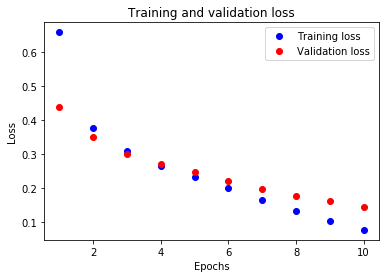

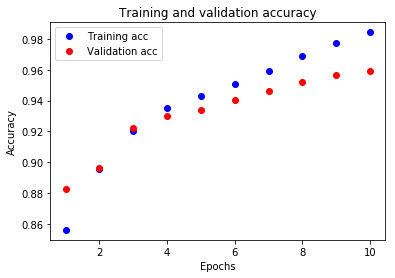

In [34]:
vis_loss(easy_simple_history)
vis_acc(easy_simple_history)

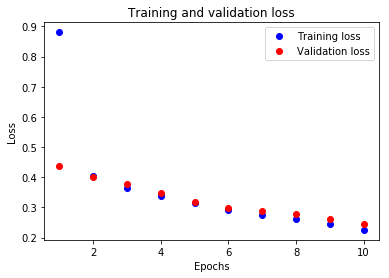

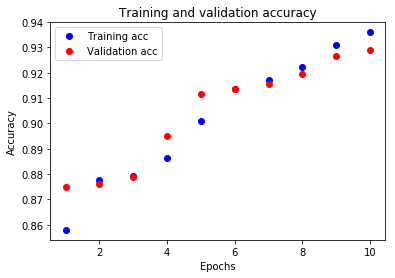

In [35]:
vis_loss(easy_lstm_history)
vis_acc(easy_lstm_history)

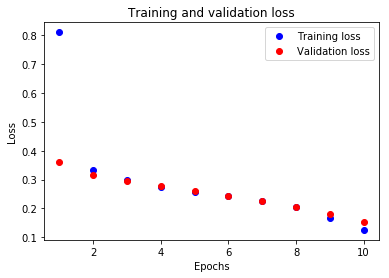

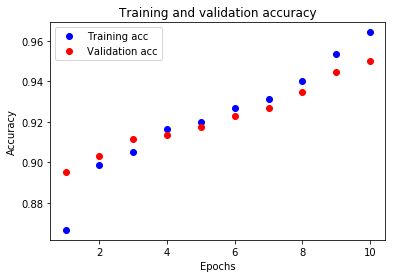

In [36]:
vis_loss(easy_bilstm_history)
vis_acc(easy_bilstm_history)

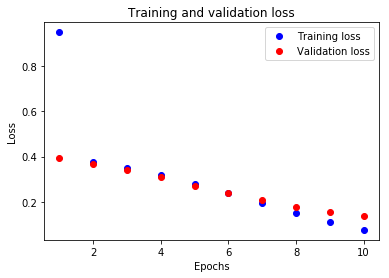

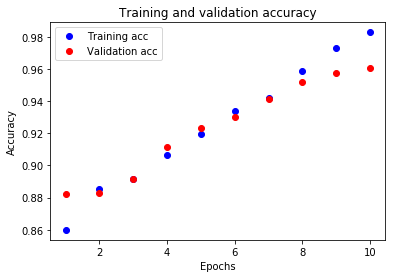

In [37]:
vis_loss(easy_gru_history)
vis_acc(easy_gru_history)

In [38]:
# нигде снова не переобучились, ура-ура

## Оценка

In [39]:
# последняя, не будем подгружать
easy_simple_evals = easy_simple.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [40]:
easy_lstm_evals = easy_lstm.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [41]:
easy_bilstm_evals = easy_bilstm.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [42]:
easy_gru_evals = easy_gru.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [43]:
print('''
\tLoss\tAcc
Simple:\t{}\t{}
LSTM:\t{}\t{}
BiLSTM:\t{}\t{}
GRU:\t{}\t{}'''.format(
    round(easy_simple_evals[0], 5), round(easy_simple_evals[1], 5),
    round(easy_lstm_evals[0], 5), round(easy_lstm_evals[1], 5),
    round(easy_bilstm_evals[0], 5), round(easy_bilstm_evals[1], 5), 
    round(easy_gru_evals[0], 5), round(easy_gru_evals[1], 5)))


	Loss	Acc
Simple:	0.14977	0.95957
LSTM:	0.25046	0.92684
BiLSTM:	0.16054	0.94833
GRU:	0.13954	0.96071


In [45]:
def decode_sequences(preds): 
    dec_tags = []
    dec_seqs = []
    for i, pred in enumerate(preds):
        #print(i, pred.shape)
        dec_seq = []
        for vector in pred:
            #print(vector.shape, vector)
            max_idx = np.argmax(vector)
            #print(max_idx, np.max(vector))
            #print()
            dec_seq.append(max_idx)
            #print(i, dec_seq)
        dec_seqs.append(dec_seq)
        
        decoded = [i2t[idx] for idx in dec_seq if idx != 0] # обрубаем маддинги
        #print(decoded)
        dec_tags.append(decoded)
        #print('+'*50)
    return dec_seqs, dec_tags

In [46]:
easy_simple_pred = easy_simple.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_simple_pred.shape)
easy_simple_seqs, easy_simple_tags = decode_sequences(easy_simple_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_simple_tags[i])
    print()

(960, 68, 19)
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['part', 'noun', 'sconj', 'verb', 'noun', 'noun', 'punct', 'pron', 'verb', 'noun', 'noun', 'adj', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'sconj', 'verb', 'part', 'noun', 'noun', 'adv', 'noun', 'noun', 'noun', 'punct']



In [47]:
easy_lstm_pred = easy_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_lstm_pred.shape)
easy_lstm_seqs, easy_lstm_tags = decode_sequences(easy_lstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_lstm_tags[i])
    print()

(960, 68, 19)
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct', 'noun', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']



In [48]:
easy_bilstm_pred = easy_bilstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_bilstm_pred.shape)
easy_bilstm_seqs, easy_bilstm_tags = decode_sequences(easy_bilstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_bilstm_tags[i])
    print()

(960, 68, 19)
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['adv', 'noun', 'verb', 'noun', 'noun', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'adj']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['noun', 'noun', 'noun', 'noun', 'noun', 'verb', 'verb', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'verb', 'noun', 'verb', 'adv', 'noun', 'verb', 'noun', 'punct']



In [49]:
easy_gru_pred = easy_gru.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_gru_pred.shape)
easy_gru_seqs, easy_gru_tags = decode_sequences(easy_gru_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_gru_tags[i])
    print()

(960, 68, 19)
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['part', 'noun', 'sconj', 'noun', 'noun', 'noun', 'punct', 'pron', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'sconj', 'verb', 'part', 'propn', 'adj', 'adv', 'propn', 'noun', 'noun', 'punct']



In [50]:
def bleu_eval(target, predicted):
    bleu_1, bleu_2, bleu_3, bleu_4 = 0, 0, 0, 0 
    sm = SmoothingFunction()
    for t, p in zip(target, predicted):
        bleu_1 += sentence_bleu([t], p, weights=(1.0, 0, 0, 0), smoothing_function=sm.method1) # поюсуем эпсилон
        bleu_2 += sentence_bleu([t], p, weights=(0.5, 0.5, 0, 0), smoothing_function=sm.method1)
        bleu_3 += sentence_bleu([t], p, weights=(0.3, 0.3, 0.3, 0), smoothing_function=sm.method1)
        bleu_4 += sentence_bleu([t], p, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=sm.method1)
    bleu_1 = bleu_1/len(target)
    bleu_2 = bleu_2/len(target)
    bleu_3 = bleu_3/len(target)
    bleu_4 = bleu_4/len(target)
    return bleu_1, bleu_2, bleu_3, bleu_4

In [51]:
simple_bleu_1, simple_bleu_2, simple_bleu_3, simple_bleu_4 = bleu_eval(test_tags[:1088], easy_simple_tags)

In [52]:
lstm_bleu_1, lstm_bleu_2, lstm_bleu_3, lstm_bleu_4 = bleu_eval(test_tags[:1088], easy_lstm_tags)

In [53]:
bilstm_bleu_1, bilstm_bleu_2, bilstm_bleu_3, bilstm_bleu_4 = bleu_eval(test_tags[:1088], easy_bilstm_tags)

In [54]:
gru_bleu_1, gru_bleu_2, gru_bleu_3, gru_bleu_4 = bleu_eval(test_tags[:1088], easy_gru_tags)

In [55]:
print('''
\t\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
SimpleRNN:\t{}\t{}\t{}\t{}
LSTM\t\t{}\t{}\t{}\t{}
BiLSTM:\t\t{}\t{}\t{}\t{}
GRU:\t\t{}\t{}\t{}\t{}
'''.format(round(simple_bleu_1, 3), round(simple_bleu_2, 3), round(simple_bleu_3, 3), round(simple_bleu_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bilstm_bleu_1, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_4, 3),
           round(gru_bleu_1, 3), round(gru_bleu_2, 3), round(gru_bleu_3, 3), round(gru_bleu_4, 3)))


		BLEU-1	BLEU-2	BLEU-3	BLEU-4
SimpleRNN:	0.711	0.569	0.465	0.343
LSTM		0.51	0.319	0.319	0.125
BiLSTM:		0.651	0.487	0.487	0.26
GRU:		0.692	0.559	0.465	0.346



LSTM снова хуже всех, но и в целом у всех моделей результаты не ахти. Но у нас 60% тестовых слов не было в тренировочном корпусе, а тегов довольно много. Снова поигремся с LSTM

# Эксперименты с размерностью

### 64

In [56]:
lstm_64 = Sequential()
lstm_64.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_64.add(LSTM(64, return_sequences=True, unroll=True))
lstm_64.add(Dense(n_tags, activation="softmax"))

lstm_64.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 68, 64)            42240     
_________________________________________________________________
dense_5 (Dense)              (None, 68, 19)            1235      
Total params: 1,424,375
Trainable params: 1,424,375
Non-trainable params: 0
_________________________________________________________________


In [57]:
checkpoint = ModelCheckpoint('fi\\easy-lstm\\fi-64_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_64_history = lstm_64.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_64_history.history, open('fi\\easy-lstm\\fi-64_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 59s 1s/step - loss: 1.1437 - acc: 0.8580 - val_loss: 0.4482 - val_acc: 0.8738

Epoch 00001: saving model to fi\easy-lstm\fi-64_model-1.h5
Epoch 2/10
50/50 [==============================] - 14s 276ms/step - loss: 0.4066 - acc: 0.8775 - val_loss: 0.4019 - val_acc: 0.8748

Epoch 00002: saving model to fi\easy-lstm\fi-64_model-2.h5
Epoch 3/10
50/50 [==============================] - 13s 270ms/step - loss: 0.3717 - acc: 0.8809 - val_loss: 0.3703 - val_acc: 0.8825

Epoch 00003: saving model to fi\easy-lstm\fi-64_model-3.h5
Epoch 4/10
50/50 [==============================] - 15s 295ms/step - loss: 0.3448 - acc: 0.8860 - val_loss: 0.3407 - val_acc: 0.8997

Epoch 00004: saving model to fi\easy-lstm\fi-64_model-4.h5
Epoch 5/10
50/50 [==============================] - 13s 268ms/step - loss: 0.3164 - acc: 0.9032 - val_loss: 0.3155 - val_acc: 0.9182

Epoch 00005: saving model to fi\easy-lstm\fi-64_model-5.h5
Epoch 6/10
50/50 [====================

### 256

In [58]:
lstm_256 = Sequential()
lstm_256.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_256.add(LSTM(256, return_sequences=True, unroll=True))
lstm_256.add(Dense(n_tags, activation="softmax"))

lstm_256.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_256.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 68, 256)           365568    
_________________________________________________________________
dense_6 (Dense)              (None, 68, 19)            4883      
Total params: 1,751,351
Trainable params: 1,751,351
Non-trainable params: 0
_________________________________________________________________


In [59]:
checkpoint = ModelCheckpoint('fi\\easy-lstm\\fi-256_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_256_history = lstm_256.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_256_history.history, open('fi\\easy-lstm\\fi-256_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 148s 3s/step - loss: 0.7608 - acc: 0.8741 - val_loss: 0.4247 - val_acc: 0.8742

Epoch 00001: saving model to fi\easy-lstm\fi-256_model-1.h5
Epoch 2/10
50/50 [==============================] - 106s 2s/step - loss: 0.3911 - acc: 0.8755 - val_loss: 0.3681 - val_acc: 0.8748

Epoch 00002: saving model to fi\easy-lstm\fi-256_model-2.h5
Epoch 3/10
50/50 [==============================] - 104s 2s/step - loss: 0.3522 - acc: 0.8781 - val_loss: 0.3492 - val_acc: 0.8821

Epoch 00003: saving model to fi\easy-lstm\fi-256_model-3.h5
Epoch 4/10
50/50 [==============================] - 106s 2s/step - loss: 0.3337 - acc: 0.8869 - val_loss: 0.3409 - val_acc: 0.8996

Epoch 00004: saving model to fi\easy-lstm\fi-256_model-4.h5
Epoch 5/10
50/50 [==============================] - 105s 2s/step - loss: 0.3160 - acc: 0.8972 - val_loss: 0.3180 - val_acc: 0.9082

Epoch 00005: saving model to fi\easy-lstm\fi-256_model-5.h5
Epoch 6/10
50/50 [======================

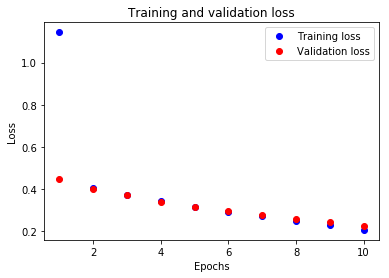

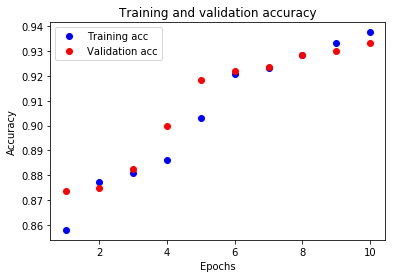

In [60]:
vis_loss(lstm_64.history)
vis_acc(lstm_64.history)

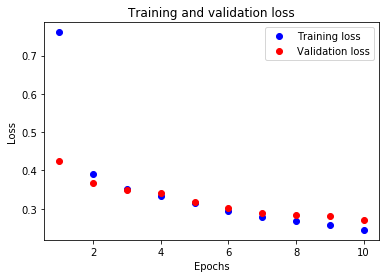

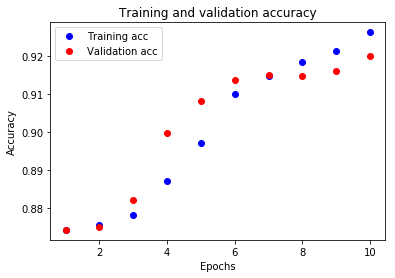

In [61]:
vis_loss(lstm_256.history)
vis_acc(lstm_256.history)

Это похоже на цепочку ДНК)

In [62]:
evals_64 = lstm_64.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [63]:
evals_256 = lstm_256.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [64]:
print('''
\tLoss\tAcc
64:\t{}\t{}
128:\t{}\t{}
256:\t{}\t{}'''.format(
    round(evals_64[0], 5), round(evals_64[1], 5),
    round(easy_lstm_evals[0], 5), round(easy_lstm_evals[1], 5),
    round(evals_256[0], 5), round(evals_256[1], 5)))


	Loss	Acc
64:	0.23225	0.9315
128:	0.25046	0.92684
256:	0.27986	0.91906


In [65]:
pred_64 = lstm_64.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_64, tags_64 = decode_sequences(pred_64)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_64[i])
    print()

['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct', 'noun', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']



In [66]:
# хотя эо модель с лучшей точностью из трёх, всё равно как-то не очень

In [67]:
# это старое
easy_lstm_pred = easy_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_lstm_pred.shape)
easy_lstm_seqs, easy_lstm_tags = decode_sequences(easy_lstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_lstm_tags[i])
    print()

(960, 68, 19)
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct', 'noun', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']



In [68]:
pred_256 = lstm_256.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_256, tags_256 = decode_sequences(pred_256)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_256[i])
    print()

['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['verb', 'verb', 'verb', 'verb', 'verb', 'noun', 'noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'punct']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'verb', 'verb', 'verb', 'verb', 'verb', 'noun', 'noun', 'punct']



In [69]:
bleu_64_1, bleu_64_2, bleu_64_3, bleu_64_4 = bleu_eval(test_tags[:1088], tags_64)

In [70]:
bleu_256_1, bleu_256_2, bleu_256_3, bleu_256_4 = bleu_eval(test_tags[:1088], tags_256)

In [71]:
print('''
\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
64:\t{}\t{}\t{}\t{}
128\t{}\t{}\t{}\t{}
256:\t{}\t{}\t{}\t{}
'''.format(round(bleu_64_1, 3), round(bleu_64_2, 3), round(bleu_64_3, 3), round(bleu_64_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bleu_256_1, 3), round(bleu_256_2, 3), round(bleu_256_2, 3), round(bleu_256_4, 3)))


	BLEU-1	BLEU-2	BLEU-3	BLEU-4
64:	0.523	0.341	0.235	0.138
128	0.51	0.319	0.319	0.125
256:	0.469	0.289	0.289	0.112



In [73]:
# 64 капельку лучше на 1, 2 и 4 но зато сильно хуже на триграммах, так что его мы не возьмём

# Эксперименты с эмбеддингами

### 50

In [74]:
lstm_50 = Sequential()
lstm_50.add(Embedding(n_words, 50, input_length=max_len))
lstm_50.add(LSTM(n_hidden, return_sequences=True, unroll=True))
lstm_50.add(Dense(n_tags, activation="softmax"))

lstm_50.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 68, 50)            690450    
_________________________________________________________________
lstm_5 (LSTM)                (None, 68, 128)           91648     
_________________________________________________________________
dense_7 (Dense)              (None, 68, 19)            2451      
Total params: 784,549
Trainable params: 784,549
Non-trainable params: 0
_________________________________________________________________


In [75]:
checkpoint = ModelCheckpoint('fi\\easy-lstm\\fi-50_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_50_history = lstm_50.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_50_history.history, open('fi\\easy-lstm\\fi-50_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 104s 2s/step - loss: 0.9956 - acc: 0.8405 - val_loss: 0.4695 - val_acc: 0.8738

Epoch 00001: saving model to fi\easy-lstm\fi-50_model-1.h5
Epoch 2/10
50/50 [==============================] - 61s 1s/step - loss: 0.4291 - acc: 0.8755 - val_loss: 0.4244 - val_acc: 0.8751

Epoch 00002: saving model to fi\easy-lstm\fi-50_model-2.h5
Epoch 3/10
50/50 [==============================] - 61s 1s/step - loss: 0.3793 - acc: 0.8778 - val_loss: 0.3886 - val_acc: 0.8780

Epoch 00003: saving model to fi\easy-lstm\fi-50_model-3.h5
Epoch 4/10
50/50 [==============================] - 57s 1s/step - loss: 0.3514 - acc: 0.8812 - val_loss: 0.3687 - val_acc: 0.8843

Epoch 00004: saving model to fi\easy-lstm\fi-50_model-4.h5
Epoch 5/10
50/50 [==============================] - 57s 1s/step - loss: 0.3280 - acc: 0.8926 - val_loss: 0.3820 - val_acc: 0.8957

Epoch 00005: saving model to fi\easy-lstm\fi-50_model-5.h5
Epoch 6/10
50/50 [==============================]

### 150

In [76]:
lstm_150 = Sequential()
lstm_150.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_150.add(LSTM(256, return_sequences=True, unroll=True))
lstm_150.add(Dense(n_tags, activation="softmax"))

lstm_150.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_150.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 68, 100)           1380900   
_________________________________________________________________
lstm_6 (LSTM)                (None, 68, 256)           365568    
_________________________________________________________________
dense_8 (Dense)              (None, 68, 19)            4883      
Total params: 1,751,351
Trainable params: 1,751,351
Non-trainable params: 0
_________________________________________________________________


In [77]:
checkpoint = ModelCheckpoint('fi\\easy-lstm\\fi-150_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_150_history = lstm_150.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_150_history.history, open('fi\\easy-lstm\\fi-150_model-history.json','w', encoding='utf-8'))

Epoch 1/10
50/50 [==============================] - 213s 4s/step - loss: 0.7601 - acc: 0.8576 - val_loss: 0.4319 - val_acc: 0.8752

Epoch 00001: saving model to fi\easy-lstm\fi-150_model-1.h5
Epoch 2/10
50/50 [==============================] - 175s 3s/step - loss: 0.3912 - acc: 0.8797 - val_loss: 0.3648 - val_acc: 0.8776

Epoch 00002: saving model to fi\easy-lstm\fi-150_model-2.h5
Epoch 3/10
50/50 [==============================] - 177s 4s/step - loss: 0.3454 - acc: 0.8831 - val_loss: 0.3364 - val_acc: 0.8930

Epoch 00003: saving model to fi\easy-lstm\fi-150_model-3.h5
Epoch 4/10
50/50 [==============================] - 168s 3s/step - loss: 0.3142 - acc: 0.8993 - val_loss: 0.3177 - val_acc: 0.9098

Epoch 00004: saving model to fi\easy-lstm\fi-150_model-4.h5
Epoch 5/10
50/50 [==============================] - 164s 3s/step - loss: 0.2887 - acc: 0.9121 - val_loss: 0.2936 - val_acc: 0.9134

Epoch 00005: saving model to fi\easy-lstm\fi-150_model-5.h5
Epoch 6/10
50/50 [======================

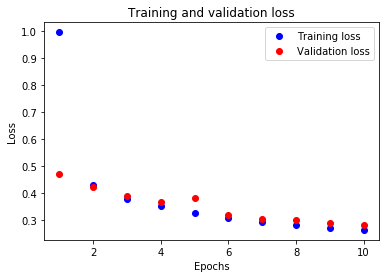

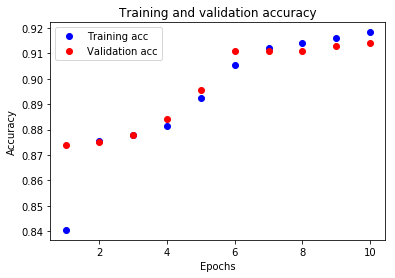

In [78]:
vis_loss(lstm_50.history)
vis_acc(lstm_50.history)

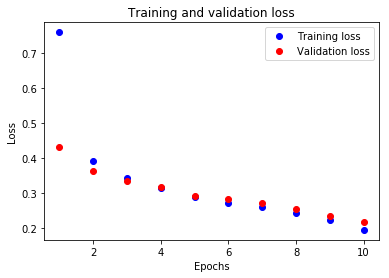

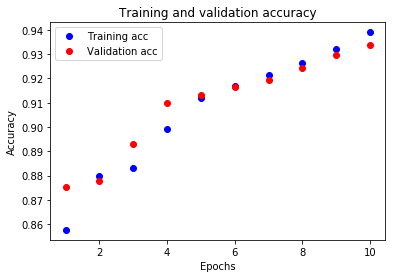

In [79]:
vis_loss(lstm_150.history)
vis_acc(lstm_150.history)

In [80]:
evals_50 = lstm_50.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [81]:
evals_150 = lstm_150.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [82]:
print('''
\tLoss\tAcc
50:\t{}\t{}
100:\t{}\t{}
150:\t{}\t{}'''.format(
    round(evals_50[0], 5), round(evals_50[1], 5),
    round(easy_lstm_evals[0], 5), round(easy_lstm_evals[1], 5),
    round(evals_150[0], 5), round(evals_150[1], 5)))


	Loss	Acc
50:	0.29219	0.91144
100:	0.25046	0.92684
150:	0.22627	0.9322


In [83]:
pred_50 = lstm_50.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_50, tags_50 = decode_sequences(pred_50)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_64[i])
    print()

['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct', 'noun', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']



In [85]:
# это старое
easy_lstm_pred = easy_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_lstm_pred.shape)
easy_lstm_seqs, easy_lstm_tags = decode_sequences(easy_lstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_lstm_tags[i])
    print()

(960, 68, 19)
['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct', 'noun', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']



In [86]:
pred_150 = lstm_150.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_150, tags_150 = decode_sequences(pred_150)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_150[i])
    print()

['part', 'noun', 'sconj', 'noun', 'verb', 'noun', 'punct', 'pron', 'verb', 'verb', 'noun', 'num']
['cconj', 'noun', 'verb', 'noun', 'noun', 'noun', 'punct', 'sconj', 'verb', 'noun', 'noun', 'noun', 'noun']

['noun', 'verb', 'verb', 'noun', 'noun', 'noun', 'verb', 'noun', 'punct']
['verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']

['intj', 'sconj', 'verb', 'part', 'num', 'noun', 'adv', 'propn', 'propn', 'verb', 'punct']
['verb', 'verb', 'verb', 'verb', 'noun', 'noun', 'noun', 'noun', 'noun', 'noun', 'punct']



In [87]:
bleu_50_1, bleu_50_2, bleu_50_3, bleu_50_4 = bleu_eval(test_tags[:1088], tags_50)

In [88]:
bleu_150_1, bleu_150_2, bleu_150_3, bleu_150_4 = bleu_eval(test_tags[:1088], tags_150)

In [89]:
print('''
\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
64:\t{}\t{}\t{}\t{}
128\t{}\t{}\t{}\t{}
150:\t{}\t{}\t{}\t{}
'''.format(round(bleu_50_1, 3), round(bleu_50_2, 3), round(bleu_50_3, 3), round(bleu_50_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bleu_150_1, 3), round(bleu_150_2, 3), round(bleu_150_2, 3), round(bleu_150_4, 3)))


	BLEU-1	BLEU-2	BLEU-3	BLEU-4
64:	0.449	0.26	0.172	0.098
128	0.51	0.319	0.319	0.125
150:	0.546	0.354	0.354	0.148



Иииии эмбеддинги снова всё улучшили)

In [91]:
print('''
\t\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
SimpleRNN:\t{}\t{}\t{}\t{}
LSTM:\t\t{}\t{}\t{}\t{}
LSTM-150:\t{}\t{}\t{}\t{}
BiLSTM:\t\t{}\t{}\t{}\t{}
GRU:\t\t{}\t{}\t{}\t{}
'''.format(round(simple_bleu_1, 3), round(simple_bleu_2, 3), round(simple_bleu_3, 3), round(simple_bleu_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bleu_150_1, 3), round(bleu_150_2, 3), round(bleu_150_2, 3), round(bleu_150_4, 3),
           round(bilstm_bleu_1, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_4, 3),
           round(gru_bleu_1, 3), round(gru_bleu_2, 3), round(gru_bleu_3, 3), round(gru_bleu_4, 3)))


		BLEU-1	BLEU-2	BLEU-3	BLEU-4
SimpleRNN:	0.711	0.569	0.465	0.343
LSTM:		0.51	0.319	0.319	0.125
LSTM-150:	0.546	0.354	0.354	0.148
BiLSTM:		0.651	0.487	0.487	0.26
GRU:		0.692	0.559	0.465	0.346



In [92]:
# собратьев не догнали, но точность всё равно повысили. Видимо, эмбеддинги размерностью 100 недостаточно информации о слове сохраняли.